# Analisi Fianziaria di Criptovalute

# 0. Analisi del Mercato

In [1]:
import os, pandas as pd, scipy as sc, scipy.stats as stats, numpy as np, seaborn as sns, seaborn.objects as so, matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from rich.console import Console
from rich.table import Table
import DataExtractor

# 1. Estrazione dei Dati
I dati sono stati estratti dal sito *Yahoo Finance* usando delle REST API. I dati sono stati scaricati per tre criptovalute: <br>
* Ethereum <br>
* Bitcoin <br>
* Binance <br>

I dati sono stati scaricati per l'intervallo temporale tra *2018-01-01* e *2023-10-01* <br>

In [2]:
cryptoList : list[str] = ["ETH-USD", "BTC-USD", "BNB-USD"]

In [3]:
startDate : str = "2018-01-01"
endDate : str = "2023-10-01"
interval : str = "daily"

for crypto in cryptoList :
    DataExtractor.extractData(crypto, startDate, endDate, interval)

In [4]:
cryptoDataFrameDict : dict[str, pd.DataFrame] = {}
for crypto in cryptoList :
    inputFileName : str = crypto + "_Data.csv"
    inputFilePath = os.path.join("./", "datasets", inputFileName)
    dataFrame : pd.DataFrame = pd.read_csv(filepath_or_buffer = inputFilePath)
    cryptoDataFrameDict[crypto] = dataFrame 

In [5]:
#cryptoDataFrameDict["ETH-USD"].describe
print(cryptoDataFrameDict["BTC-USD"].describe)
print(cryptoDataFrameDict["ETH-USD"].describe)

<bound method NDFrame.describe of             Date          Open          High           Low         Close  \
0     2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
1     2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2     2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
3     2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
4     2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   
...          ...           ...           ...           ...           ...   
2095  2023-09-27  26209.498047  26817.841797  26111.464844  26352.716797   
2096  2023-09-28  26355.812500  27259.500000  26327.322266  27021.546875   
2097  2023-09-29  27024.841797  27225.937500  26721.763672  26911.720703   
2098  2023-09-30  26911.689453  27091.794922  26888.968750  26967.916016   
2099  2023-10-01  26967.396484  28047.238281  26965.093750  27983.750000   

         Adj Close       Volume  
0     13657.200195 

## 2. Analisi del Dataset

### 2_1. Passaggio al Logaritmo

In [6]:
def logConvertion(dataFrame : pd.DataFrame, columnName : str) :
    dataFrame["LogClosePrice"] = np.log10(dataFrame[columnName])

In [7]:
for crypto in cryptoList :
    cryptoDf : pd.DataFrame = cryptoDataFrameDict[crypto]
    logConvertion(cryptoDf, "Close")

cryptoDataFrameDict["ETH-USD"]["LogClosePrice"]

0       2.887978
1       2.946670
2       2.983500
3       2.991634
4       2.999009
          ...   
2095    3.203438
2096    3.218242
2097    3.222181
2098    3.223019
2099    3.239002
Name: LogClosePrice, Length: 2100, dtype: float64

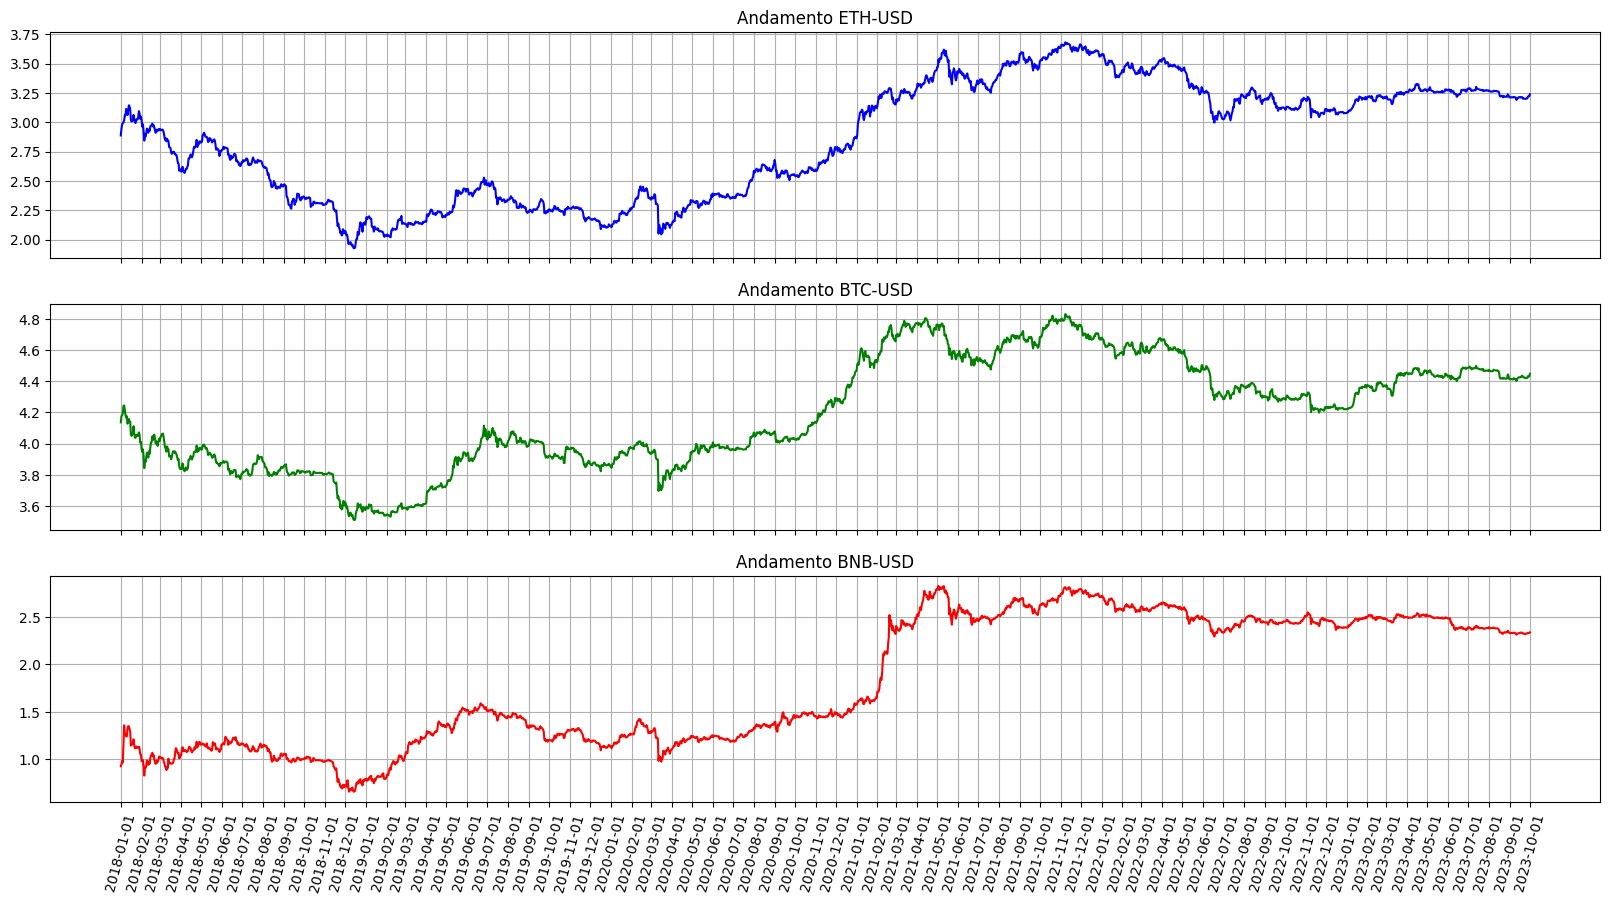

<Figure size 640x480 with 0 Axes>

In [8]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure

colors = ["blue", "green", "red"]
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(cryptoDataFrameDict[crypto]["LogClosePrice"], color = colors[i % len(colors)])
    axs[i].set_title("Andamento " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 75)

plt.show()
plt.clf()

### 2_2. Ricerca di una componenti di Random Walk
Le componenti di Random Walk vengono ricercate usando due Test di Ipotesi:
* Adfuller
* KPSS

Nel test di KPSS abbiamo:
* *H0* : La serie è stazionaria attorno a una tendenza deterministica (NON ha componente di Random Walk)
* *H1* : La serie non è stazionaria (HA componente di Random Walk)

Nel test di Adfuller abbiamo:
* *H0* : La serie ha una radice unitaria (HA componente di Random Walk)
* *H1* : La serie non ha una radice unitaria (NON ha componente di Random Walk)

Nel nostro caso vogliamo:
* Rigettare KPSS
* Accettare Adfuller

In [9]:
%%capture --no-display

SIGNIFICANCE_LEVEL = 0.05

def buildTable(testName : str) -> Table :
    table = Table(title = "Test " + testName)
    table.add_column("Crypto")
    table.add_column("StatValue", justify="right", no_wrap=True)
    table.add_column("pValue", justify = "right")
    table.add_column("Outcome")
    return table


kpssTable : Table = buildTable("KPSS")
for crypto in cryptoList :
    kpssStat, pValue, _, _ = kpss(cryptoDataFrameDict[crypto]["LogClosePrice"])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
console = Console()
console.print(kpssTable)

adfullerTable = buildTable("Adfuller")
for crypto in cryptoList :
    result = adfuller(cryptoDataFrameDict[crypto]["LogClosePrice"])
    adfullerStat : float = result[0]
    pValue = result[1]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
console = Console()
console.print(adfullerTable)

                     Test KPSS                     
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto  ┃          StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD │ 4.6868634079376505 │   0.01 │ Reject  │
│ BTC-USD │  4.852563872844437 │   0.01 │ Reject  │
│ BNB-USD │   6.14229341077486 │   0.01 │ Reject  │
└─────────┴────────────────────┴────────┴─────────┘

                         Test Adfuller                          
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto  ┃           StatValue ┃             pValue ┃ Outcome ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD │ -0.9316698059416463 │  0.777364302477946 │ Accept  │
│ BTC-USD │ -0.9795375977486941 │ 0.7606541432486269 │ Accept  │
│ BNB-USD │ -0.7871022765252597 │ 0.8228813493407746 │ Accept  │
└─────────┴─────────────────────┴────────────────────┴─────────┘

### 2_3. Differencing della serie storica e analisi del rumore

### Analisi Stazionarietà

### Analisi Eteroschedasticità

### Analisi Autocorrelazione

### Analisi Normalità